# <center> Introduction to Reinforcement Learning</center>

# Setup

#### Let us first make sure that all the required dependencies are installed

In [1]:
running_locally = True

In [2]:
import sys, os

if running_locally:
  !pip install gym matplotlib
  sys.path.append('Support')
  sys.path.insert(0, os.path.abspath('Support'))
else:
  !pip install gym
  from google.colab import drive
  drive.mount('/content/gdrive',force_remount=True)
  sys.path.append('/content/gdrive/MyDrive/Colab/ECE4078_2021_Practicals/Week07/Support')
  sys.path.insert(1, os.path.abspath('/content/gdrive/MyDrive/Colab/ECE4078_2021_Practicals/Week07/Support'))
  !ls '/content/gdrive/MyDrive/Colab/ECE4078_2021_Practicals/Week07/Support'

#### Import dependencies

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import pickle

import sys
import os

from gym_simple_gridworlds.envs.grid_env import GridEnv
from gym_simple_gridworlds.envs.grid_2dplot import *
from gym_simple_gridworlds.helper import *

#### Set up a wide cell view

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Activity 1. Elements of an MDP (Grid World Example)

Recall the grid in which our robot lives

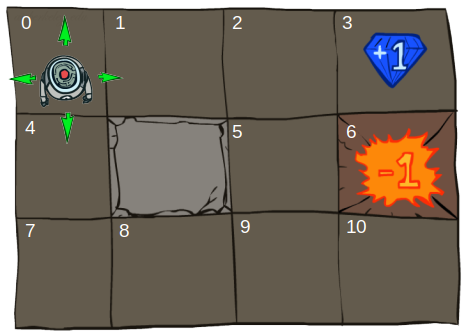

- The states $s \in \mathcal{S}$ correspond to locations in the grid. Each location has also a cell index associated to it, e.g., cell index 4 is associated to location (row=1,col=0)
- The robot can move up, down, left, or right. Actions correpond to unit increments or decrements in the specified direction.
    - Up : (-1,0)
    - Down: (1,0)
    - Left: (0,-1)
    - Right: (0, 1)
- Each action is represented by a number. Action (Up) is represented by 0, (Down) by 1, (Left) by 2 and, finally, (Right) by 3. No actions are available at a terminal state

We have defined the class ``GridEnv`` to represent our Grid World MDP. **Hover your cursor on "GridEnv", this shows more information on how the grid world instance is defined.**

## Create Environment and Explore its Attributes

The noise parameter corresponds to the probability of a change of direction when an action is taken (e.g., going left/right when agent decides to move up/down)

In [5]:
# Create a Grid World instance
grid_world = GridEnv(gamma=0.9, noise=0.2, living_reward=-0.04)

### State and Action Spaces

Let's take a look at the state and action spaces of our environment

In [6]:
# State (or observation) space
print(grid_world.observation_space)
print(grid_world.get_states())
print()

# Action space
print(grid_world.action_space)
print(grid_world.get_actions())

Discrete(11)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

Discrete(4)
[0, 1, 2, 3]


### Transition Function

Let's take a look at the current state transition function. Some things to keep in mind regarding the transition function:

1. Given that $\mathcal{T}: \mathcal{S} \times \mathcal{A} \times \mathcal{S} \rightarrow \mathbb{R}$, the ``state_transitions`` attribute of the class ``GridEnv`` corresponds to a 3-Dimensional numpy array of size $11\times4\times11$.
2. With a noise attribute set to 0.2, at state 5, if the agent chooses to move up, it will end up at:
    - state 2 with $80\%$ probability,
    - state 6 with $10\%$ probability, or
    - state 5 with $10\%$ probability

In [7]:
# at state 5 the agent takes action 0 (going up)
print(grid_world.state_transitions[5,0])

[0.  0.  0.8 0.  0.  0.1 0.1 0.  0.  0.  0. ]


### Living Reward and Reward Function

Let's now take a quick look at the living reward (i.e., running cost) and reward function $\mathcal{R}: \mathcal{S} \times \mathcal{A} \rightarrow \mathbb{R}$.

1. Living reward corresponds to the attribute ``living_rewards`` of the class ``GridEnv`` and is represented as an 1-Dimensional numpy array
2. The reward function corresponds to the attribute ``rewards`` of the class ``GridEnv`` and is also represented as a 2-Dimensional numpy array of size $11\times4$

In [8]:
# Living rewards
print("Living rewards for all states:\n{}\n".format(grid_world.immediate_rewards))

# Reward function, i.e., expected reward for taking action a at state s
print("Reward function for all state-action pairs:\n{}\n".format(grid_world.rewards))
print("The expected reward at state 5 if agent chooses to move right is: {}".format(grid_world.rewards[5,3]))

# To do (Flux Quiz 2): what is the expected reward at state 2 if the agent chooses to move right?
print("The expected reward at state 2 if agent chooses to move right is: {}".format(grid_world.rewards[2,3]))

Living rewards for all states:
[-0.04 -0.04 -0.04  1.   -0.04 -0.04 -1.   -0.04 -0.04 -0.04 -0.04]

Reward function for all state-action pairs:
[[-0.04  -0.04  -0.04  -0.04 ]
 [-0.04  -0.04  -0.04  -0.04 ]
 [ 0.064  0.064 -0.04   0.792]
 [ 0.     0.     0.     0.   ]
 [-0.04  -0.04  -0.04  -0.04 ]
 [-0.136 -0.136 -0.04  -0.808]
 [ 0.     0.     0.     0.   ]
 [-0.04  -0.04  -0.04  -0.04 ]
 [-0.04  -0.04  -0.04  -0.04 ]
 [-0.04  -0.04  -0.04  -0.04 ]
 [-0.808 -0.04  -0.136 -0.136]]

The expected reward at state 5 if agent chooses to move right is: -0.808
The expected reward at state 2 if agent chooses to move right is: 0.792


### Policy

Let's see the path and total reward of an agent moving on our grid world according to the following policy $\pi$

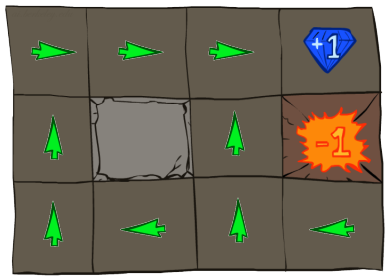

In [9]:
# We represent this policy as a 2-Dimensional numpy array
policy_matrix = np.array([[3,      3,  3,  -1],
                          [0, np.NaN,  0,  -1],
                          [0,      2,  0,   2]])

In [10]:
print(grid_world.grid)

[[ 0.  1.  2.  3.]
 [ 4. nan  5.  6.]
 [ 7.  8.  9. 10.]]


Let's now apply this policy and observe the agent's behavior (blue dot in the figure shown below).

In [12]:
# Create a Grid World instance
grid_world = GridEnv(gamma=0.9, noise=0.2, living_reward=-0.04)
s_x, s_y = get_state_to_plot(grid_world)

# We can visualize our grid world using the render() function
fig, ax = grid_world.render()
agent, = ax.plot([], [], 'o', color='b', linewidth=6)
reward_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

done = False
cumulative_reward = 0
cur_state = grid_world.cur_state
path_to_plot = []

while not done:
    _, cur_reward, done, _ = grid_world.step(int(policy_matrix[cur_state[0], cur_state[1]]))
    cur_state = grid_world.cur_state
    n_x, n_y = get_state_to_plot(grid_world)
    cumulative_reward += cur_reward
    path_to_plot.append([cumulative_reward, n_x, n_y])

def init():
    agent.set_data(s_x + 0.5, s_y + 0.5)
    reward_text.set_text('')
    return agent, reward_text

def animate(i):
    if i < len(path_to_plot):
        r, n_x, n_y = path_to_plot[i]
        agent.set_data(n_x + 0.5, n_y + 0.5)
        reward_text.set_text('Cumulative reward: %.2f' % r)
    return agent, reward_text

ani = animation.FuncAnimation(fig, animate, frames=len(path_to_plot), blit=False, interval=500, init_func=init,
                              repeat=False)

html = HTML(ani.to_html5_video())
display(html)
plt.close()

# Activity 2. Iterative Policy Evaluation

Recall the definition of the iterative policy evaluation algorithm

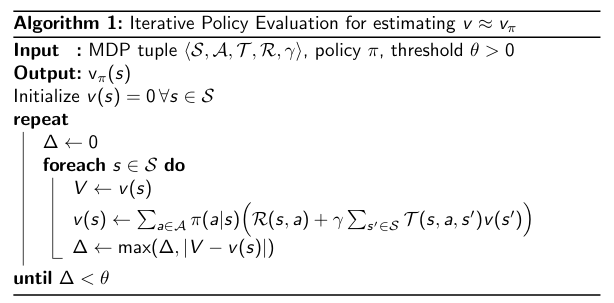

Let's now compute the value function of the same policy $\pi$ 

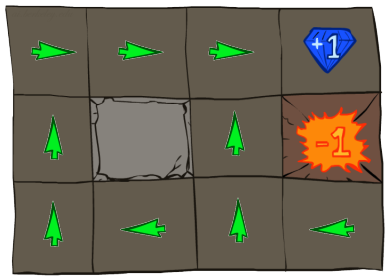

We consider a grid world environment with the following attributes:
- Discount factor $\gamma = 0.9$ (class attribute ``gamma=0.9``)
- Stochastic transition matrix (class attribute ``noise=0.2``)
- A non-zero living cost and big rewards are obtained at terminal states (class attribute ``living_reward=-0.04``)

We have defined the helper function ``encode_policy()`` to encode the policy $\pi$ shown in the image above. The return variable ``policy_pi`` is a dictionary of dictionaries, where each element corresponds to the probability of selecting an action $a$ at a given state $s$

Keep in mind that each action is represented by a number. Action (Up) is represented by 0, (Down) by 1, (Left) by 2 and, finally, (Right) by 3.

In [13]:
grid_world = GridEnv(gamma=0.9, noise=0.2, living_reward=-0.04)
policy_pi = encode_policy(grid_world)

print("Action probabilities at state 0 are:\n{}".format(policy_pi[0]))

Action probabilities at state 0 are:
defaultdict(<class 'float'>, {0: 0.0, 1: 0.0, 2: 0.0, 3: 1.0})


Given the policy $\pi$, let's know compute its state-value function using iterative policy evaluation.

**TODO** (Flux Quiz 3): 
Complete the computation of value function update for each state. We have decomposed this computation into 2 steps:

1. Compute discounted sum of state values of all successor states: $\text{discounted_v} = \gamma\sum_{s' \in \mathcal{S}}\mathcal{T}(s,a,s')v(s')$ for each action


2. Compute expectation over all actions: $\sum_{a \in \mathcal{A}}\pi(a|s)(\mathcal{R}(s,a) + \text{discounted_v})$ 


**Keep in Mind**: Correspondance between the mathematical notation and implemented code


<table style="width:20%">
<thead>
<tr>
<th style="width:150px;font-size:20px;text-align:center;">Notation</th>
<th colspan=2, style="width:450px;font-size:20px;text-align:center;">Code</th>
</tr>
    <tr>
        <td></td>
        <th style="font-size:15px;text-align:center;">Variable/Attribute</th>
        <th style="font-size:15px;text-align:center;">Type</th>
    </tr>
</thead>
<tbody>
<tr>
    <td style="text-align:left;">$\gamma$</td>
    <td style="text-align:left;font-size:15px;">grid_world.gamma</td>
    <td>float</td>
</tr>
<tr>
    <td style="text-align:left;">$\mathcal{T}(s, a, s')$</td>
    <td style="text-align:left;font-size:15px;">grid_world.state_transitions[idx_s, idx_a, idx_s]</td>
    <td>numpy 3d-array</td>
</tr>
<tr>
    <td style="text-align:left;">$\mathcal{R}(s, a)$</td>
    <td style="text-align:left;font-size:15px;">grid_world.rewards[idx_s, idx_a]</td>
    <td>numpy 2d-array</td>
</tr>
<tr>
    <td style="text-align:left;">$\pi(a|s)$</td>
    <td style="text-align:left;font-size:15px;">policy_pi[idx_s][idx_a]</td>
    <td>dict of dict</td>
</tr>
<tr>
    <td style="text-align:left;">$v_\pi(s)$</td>
    <td style="text-align:left;font-size:15px;">v[idx_s]</td>
    <td>dict</td>
</tr>
</table>

{0: 0.6104616651397075, 1: 0.7662070655051755, 2: 0.9281802698515482, 3: 0, 4: 0.48723450952435526, 5: 0.5849338398682042, 6: 0, 7: 0.3687449747446223, 8: 0.2749948818865121, 9: 0.42253986750778727, 10: 0.18486666803850094}


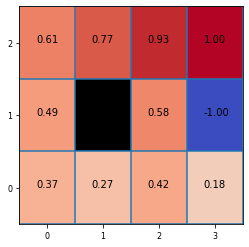

In [14]:
def policy_evaluation(grid_env, policy, plot=False, threshold=0.00001):
    
    """
    This function computes the value function for a policy pi in a given environment grid_env.
    
    :param grid_env (GridEnv): MDP environment
    :param policy (dict - stochastic form): Policy being evaluated
    :return: (dict) State-values for all non-terminal states
    """
        
    # Obtain list of all states in environment
    v = {s: 0.0 for s in grid_env.get_states()}
    theta = threshold
    delta = 1000

    while delta > theta:
        delta = 0.0
        # For all states
        for s in v.keys():

            old_v = v[s]
            new_v = 0

            # For all actions
            for a, probability_a in policy[s].items():
                discounted_v = 0

                # For all states that are reachable from s with action a
                for s_next in grid_env.get_states():
                    # TODO 1: Compute discounted sum of state values for all successor states
                    # discounted_v += 0
                    discounted_v += grid_env.state_transitions[s, a, s_next] * v[s_next]
                    
                # TODO 2: Compute expectation over all actions
                # new_v += 0
                new_v += probability_a*(grid_env.rewards[s, a] + grid_env.gamma*discounted_v)

            v[s] = new_v
            delta = max(delta, np.abs(old_v - new_v))

    if plot:
        plot_value_function(grid_env, v)
        
    return v
        

# Call the policy evalution function
v = policy_evaluation(grid_world, policy_pi, plot=True)
print(v)


# Activity 3. Policy Iteration

Recall the definition of the policy iteration algorithm

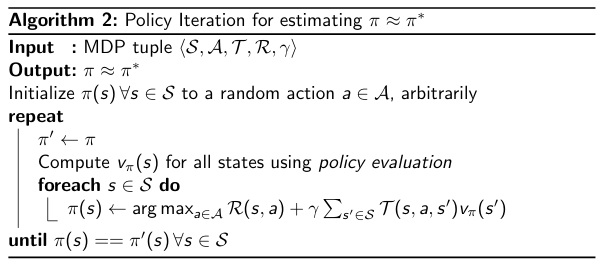

Starting with a random policy, let's find the optimal policy for a grid world environment with attributes:

We consider a grid world environment with the following attributes:
- Discount factor $\gamma = 0.9$ (class attribute ``gamma=0.9``)
- Stochastic transition matrix (class attribute ``noise=0.2``)
- Rewards are only obtained at terminal states (class attribute ``living_reward=-0.04``)

We make use of some helper methods:
- ``one_step_look_ahead(grid_env, state, value_function)`` in ``Support/gym_simple_gridworlds/helper.py``, this method computes the action-value function for a state $s$ given the state-value function $v$. This corresponds to $\mathcal{R}(s,a) + \gamma\sum_{s' \in \mathcal{S}}\mathcal{T}(s,a,s')v_\pi(s')\, \forall \, a \in \mathcal{A}$


- ``update_policy(grid_world, policy, value_function)`` in ``Support/gym_simple_gridworlds/helper.py``, this method updates the current policy $\pi$ given the state-value function $v$ by taking the action $a$ with the highest action-value. 


- ``define_random_policy(grid_env)``  in ``Support/gym_simple_gridworlds/helper.py``, this method generates a random policy for environment ``grid_env``

Let's now define the policy iteration core algorithm.

**TODO** (Flux Quiz 4): Complete the main steps of the policy iteration algoritm.
- Use ``policy_evaluation(.)`` in ``Support/gym_simple_gridworlds/helper.py`` to compute the state-value function of a given policy
- Use ``update_policy(.)`` in ``Support/gym_simple_gridworlds/helper.py`` to obtain an updated policy

In [15]:
def policy_iteration(grid_env, policy, plot=False):
    """
    This function iteratively updates a given policy pi for a given environment grid_env until convergence to optimal policy
    
    :param grid_env (GridEnv): MDP environment
    :param policy (matrix from): Deteministic policy being updated
    :return: (dict) State-values for all non-terminal states
    """
    prev_policy = np.zeros(policy.shape)
    
    while not np.all(np.equal(prev_policy, policy)):
        
        # Encode policy. This policy representation is needed for policy evaluation
        encoded_policy = encode_policy(grid_env, policy)
        # Set prev_policy to current policy
        prev_policy = policy.copy()
        
        #TODO: Complete the remaining steps
        # 1. Evaluate the given policy (policy_evaluation expects an mdp and the enconded_policy as arguments)
        value_function = policy_evaluation(grid_env, encoded_policy)
        # 2. Update policy using helper function update_policy
        value_function = policy_evaluation(grid_env, encoded_policy)
        policy = update_policy(grid_env, policy, value_function)
        
    if plot:
        plot_policy(grid_env, policy)
    
    return policy


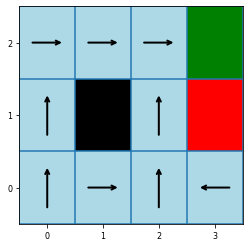

In [16]:
# Create a grid world mdp
grid_world = GridEnv(gamma=0.9, noise=0.2, living_reward=-0.04)

# Generate an initial random policy
initial_policy = define_random_policy(grid_world)

# Compute optimal policy using policy iteration
optimal_policy = policy_iteration(grid_world, initial_policy, plot=True)